In [1]:
''' install below dependencies if needed 


pip install opencv-python
pip install ultralytics
pip install tensorflow
'''

' install below dependencies if needed \n\n\npip install opencv-python\npip install ultralytics\npip install tensorflow\n'

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
#from scipy.misc import imread

import tensorflow.keras as keras
from tensorflow.keras import Model
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2

from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import accuracy_score

2024-04-17 19:25:37.806438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
data = keras.utils.image_dataset_from_directory(
    directory='../../data/Faces updated',
    labels='inferred',
    label_mode='categorical',
    batch_size=140,
    image_size=(1000, 1000),
)

Found 154 files belonging to 3 classes.


(1000, 1000, 3)


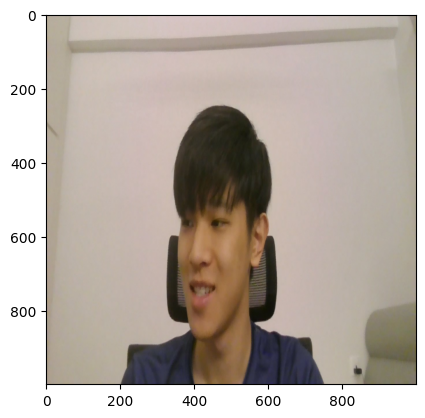

In [13]:
#plot a sample image

for images, label in data.take(1):
    print(np.array(images, dtype='uint8')[10].shape)
    imshow(np.array(images, dtype='uint8')[10])

In [14]:
#Instantiate face detector
face_classifier = cv2.CascadeClassifier(
   cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

In [15]:
face_classifier = YOLO("../../app/src/face_detection/model/yolov8n-face.pt")


In [16]:
#convert to numpy array
numpy_generator = data.as_numpy_iterator()
X, y = numpy_generator.next()

In [17]:
#get the shape of the array
X.shape

(140, 1000, 1000, 3)

In [18]:
y.shape

(140, 3)


0: 640x640 1 face, 520.6ms
Speed: 76.6ms preprocess, 520.6ms inference, 61.1ms postprocess per image at shape (1, 3, 640, 640)


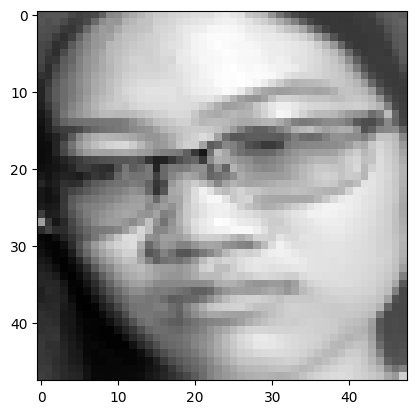


0: 640x640 1 face, 345.2ms
Speed: 7.5ms preprocess, 345.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


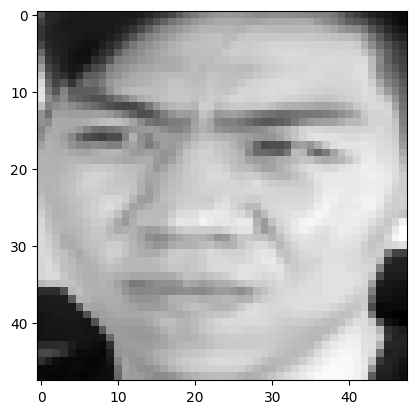


0: 640x640 1 face, 704.5ms
Speed: 17.3ms preprocess, 704.5ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


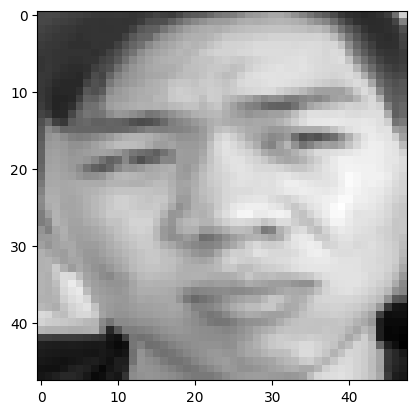


0: 640x640 1 face, 384.3ms
Speed: 14.2ms preprocess, 384.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


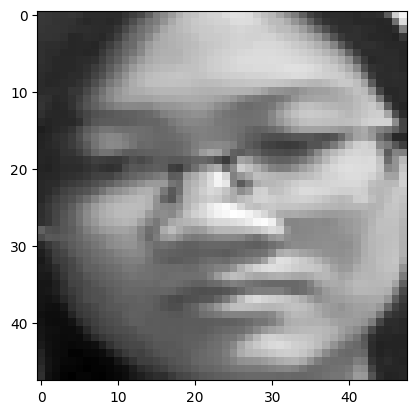


0: 640x640 1 face, 454.7ms
Speed: 26.0ms preprocess, 454.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


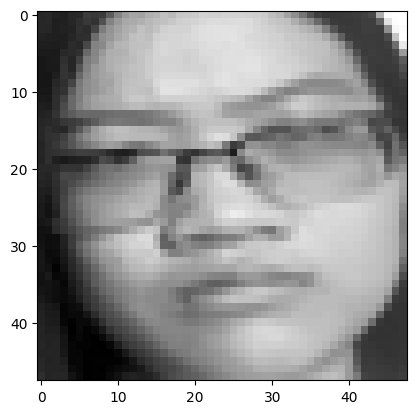


0: 640x640 1 face, 727.2ms
Speed: 17.1ms preprocess, 727.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


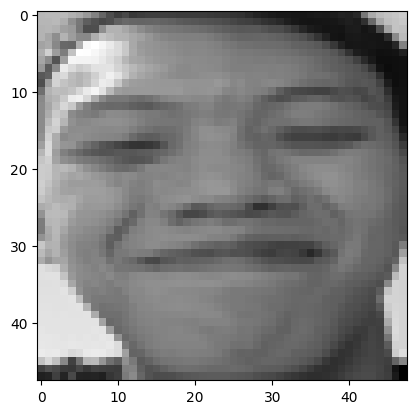


0: 640x640 (no detections), 524.3ms
Speed: 23.6ms preprocess, 524.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 397.1ms
Speed: 10.7ms preprocess, 397.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


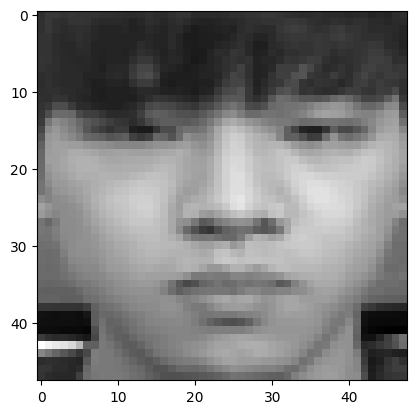


0: 640x640 1 face, 390.0ms
Speed: 11.9ms preprocess, 390.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


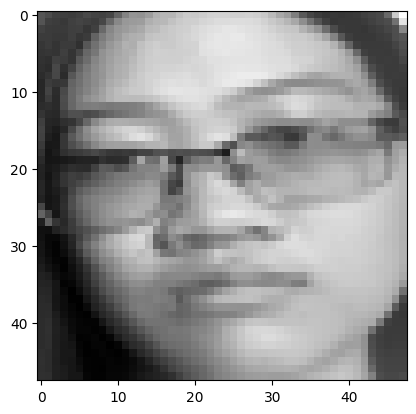


0: 640x640 1 face, 472.3ms
Speed: 9.7ms preprocess, 472.3ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


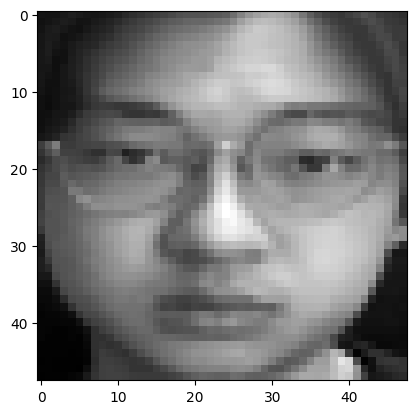


0: 640x640 1 face, 318.4ms
Speed: 7.8ms preprocess, 318.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


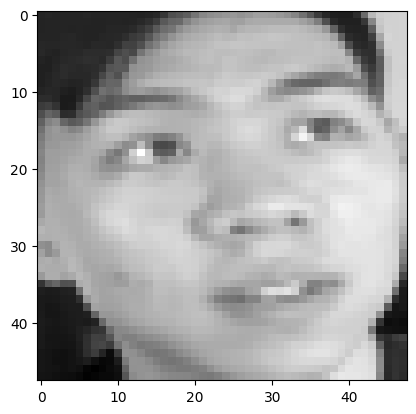


0: 640x640 1 face, 312.1ms
Speed: 10.1ms preprocess, 312.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


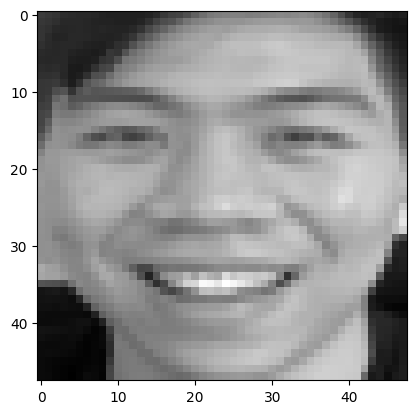


0: 640x640 1 face, 327.7ms
Speed: 9.3ms preprocess, 327.7ms inference, 11.8ms postprocess per image at shape (1, 3, 640, 640)


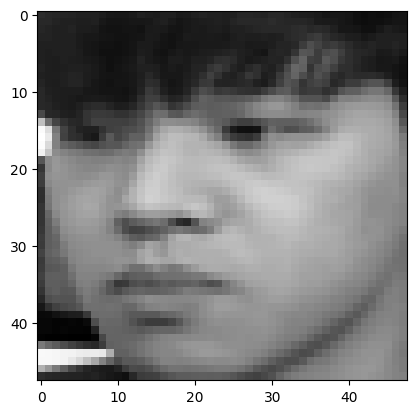


0: 640x640 1 face, 449.0ms
Speed: 7.7ms preprocess, 449.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


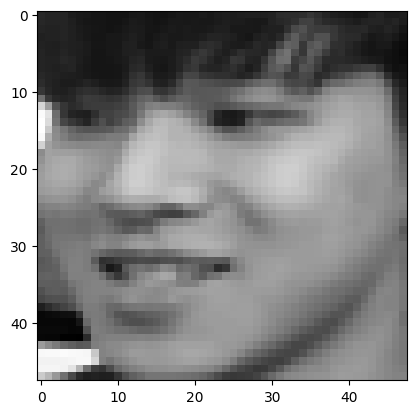


0: 640x640 1 face, 255.9ms
Speed: 5.7ms preprocess, 255.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


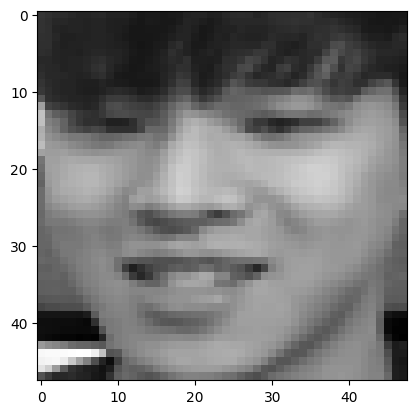


0: 640x640 1 face, 265.7ms
Speed: 6.6ms preprocess, 265.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


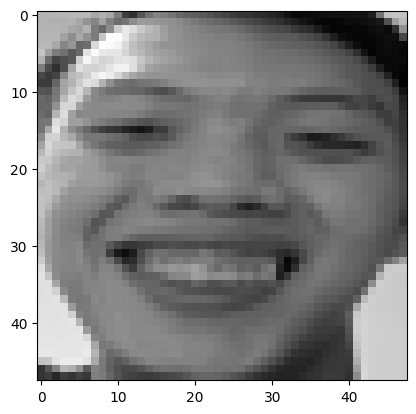


0: 640x640 (no detections), 259.7ms
Speed: 8.0ms preprocess, 259.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 236.7ms
Speed: 6.8ms preprocess, 236.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


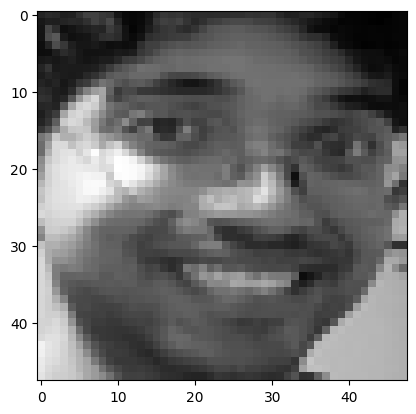


0: 640x640 1 face, 398.6ms
Speed: 8.5ms preprocess, 398.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


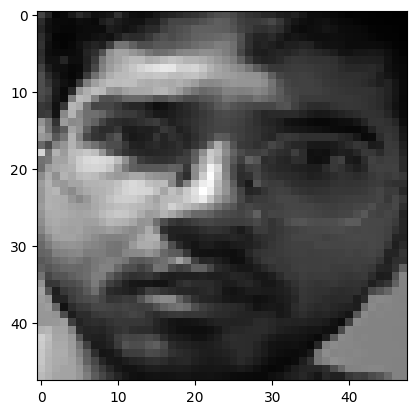


0: 640x640 1 face, 216.9ms
Speed: 5.2ms preprocess, 216.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


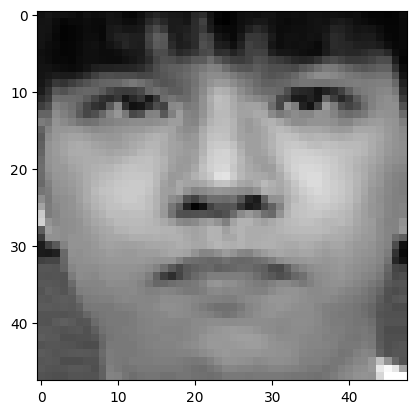


0: 640x640 1 face, 207.7ms
Speed: 5.7ms preprocess, 207.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


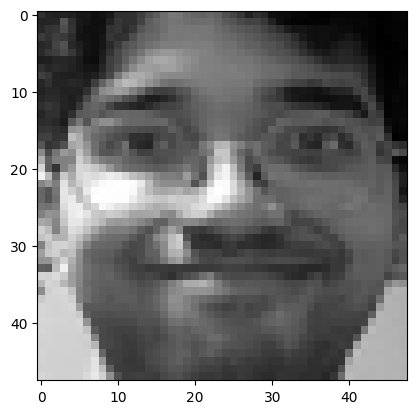


0: 640x640 1 face, 201.2ms
Speed: 5.8ms preprocess, 201.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


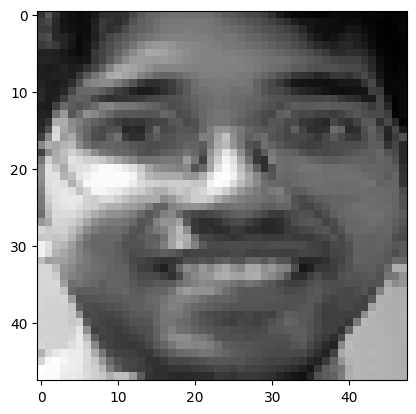


0: 640x640 1 face, 366.5ms
Speed: 6.0ms preprocess, 366.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


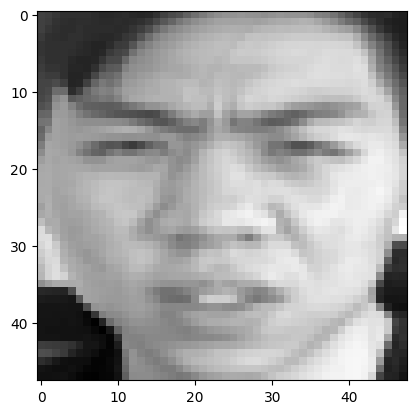


0: 640x640 1 face, 197.5ms
Speed: 5.0ms preprocess, 197.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


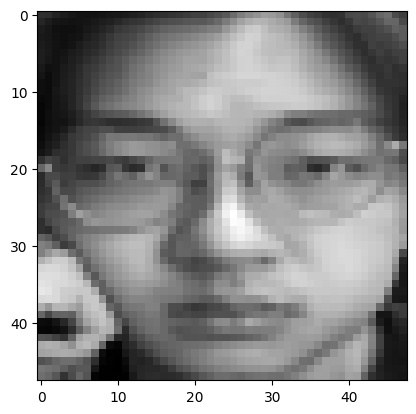


0: 640x640 1 face, 189.6ms
Speed: 5.6ms preprocess, 189.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


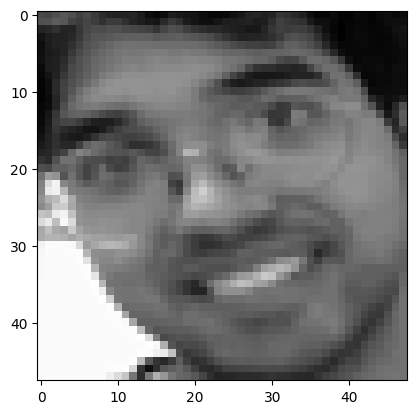


0: 640x640 1 face, 183.1ms
Speed: 5.8ms preprocess, 183.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


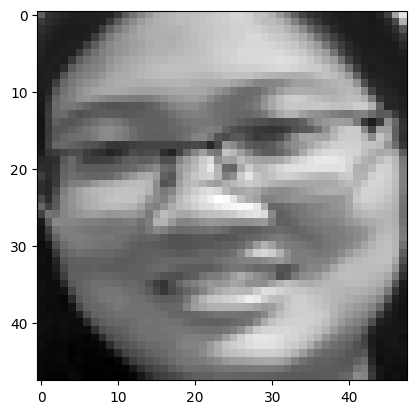


0: 640x640 1 face, 225.8ms
Speed: 6.1ms preprocess, 225.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


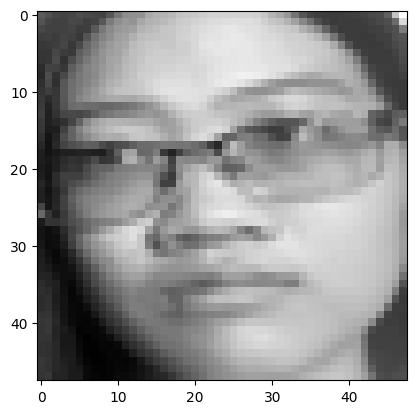


0: 640x640 1 face, 185.8ms
Speed: 5.2ms preprocess, 185.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


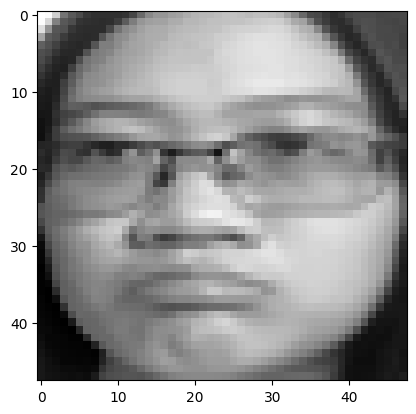


0: 640x640 (no detections), 192.8ms
Speed: 6.2ms preprocess, 192.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 178.3ms
Speed: 4.4ms preprocess, 178.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


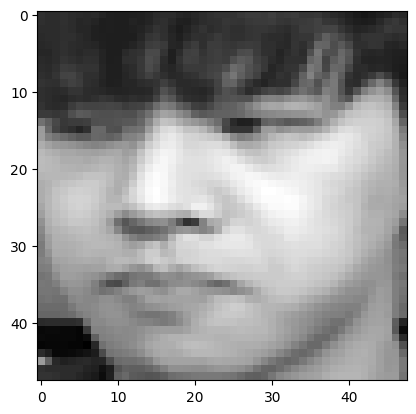


0: 640x640 1 face, 179.9ms
Speed: 5.0ms preprocess, 179.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


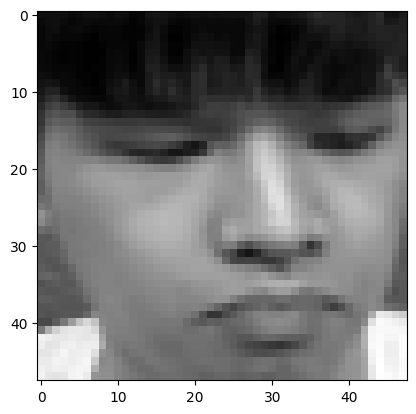


0: 640x640 1 face, 180.2ms
Speed: 5.2ms preprocess, 180.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


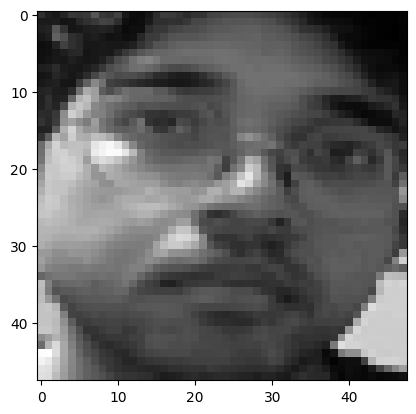


0: 640x640 1 face, 263.0ms
Speed: 34.7ms preprocess, 263.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


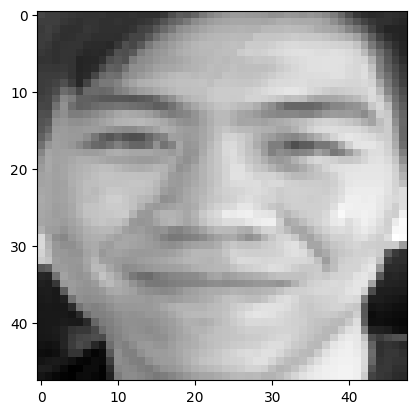


0: 640x640 1 face, 201.2ms
Speed: 6.3ms preprocess, 201.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


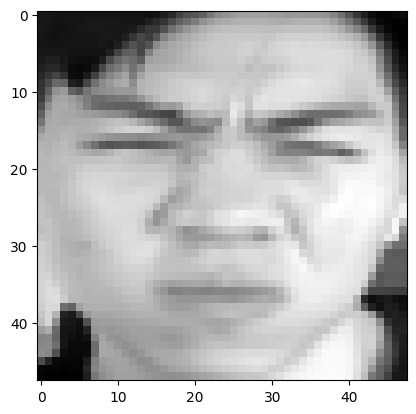


0: 640x640 1 face, 178.7ms
Speed: 5.7ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


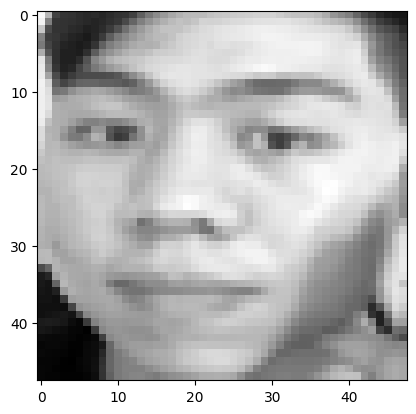


0: 640x640 1 face, 176.8ms
Speed: 4.4ms preprocess, 176.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


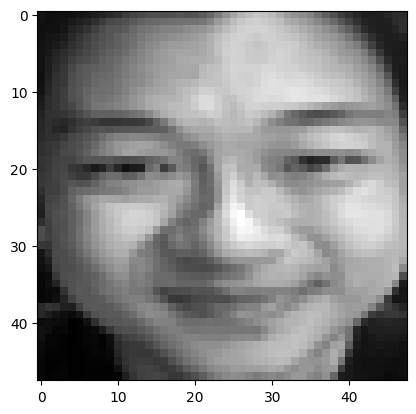


0: 640x640 1 face, 278.9ms
Speed: 4.7ms preprocess, 278.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


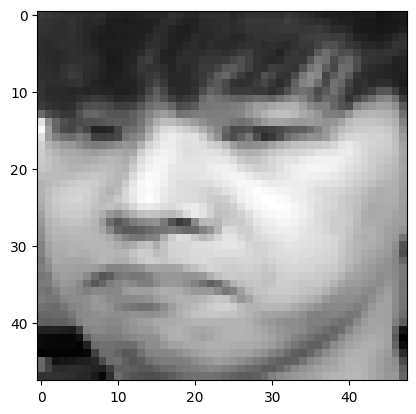


0: 640x640 1 face, 173.0ms
Speed: 5.2ms preprocess, 173.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


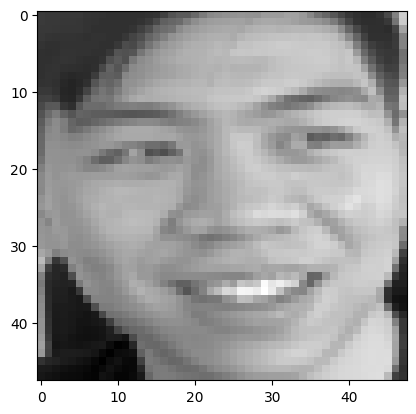


0: 640x640 2 faces, 179.2ms
Speed: 6.2ms preprocess, 179.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


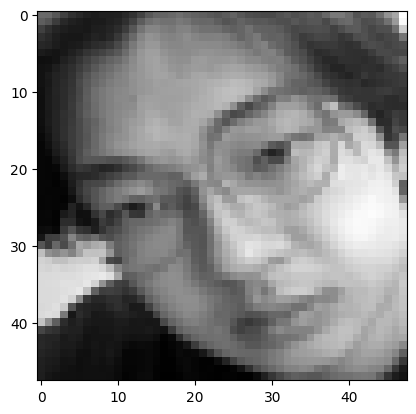


0: 640x640 1 face, 173.5ms
Speed: 6.5ms preprocess, 173.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


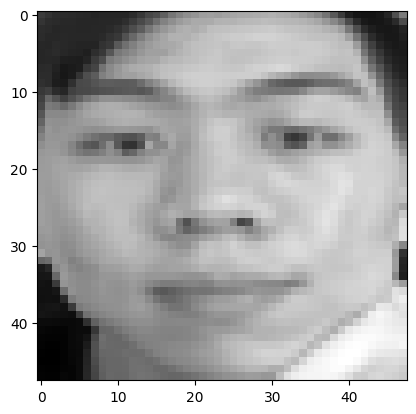


0: 640x640 1 face, 249.7ms
Speed: 5.1ms preprocess, 249.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


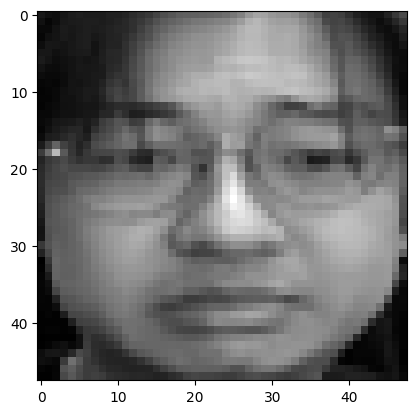


0: 640x640 1 face, 177.0ms
Speed: 4.8ms preprocess, 177.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


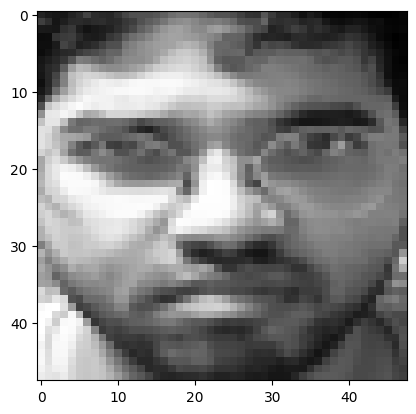


0: 640x640 1 face, 214.8ms
Speed: 5.7ms preprocess, 214.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


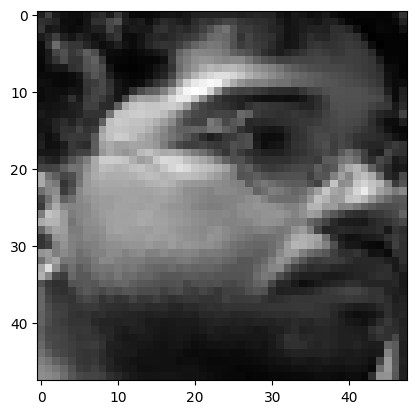


0: 640x640 1 face, 174.2ms
Speed: 4.7ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


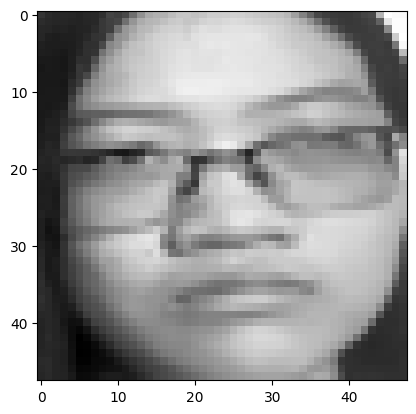


0: 640x640 1 face, 172.3ms
Speed: 4.3ms preprocess, 172.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


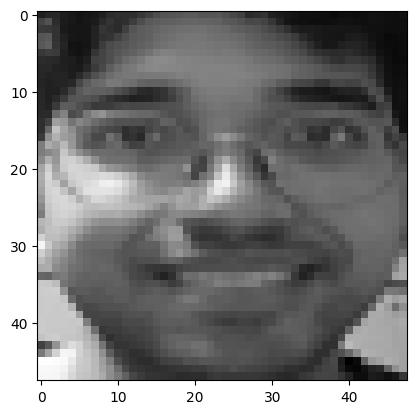


0: 640x640 1 face, 180.7ms
Speed: 4.9ms preprocess, 180.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


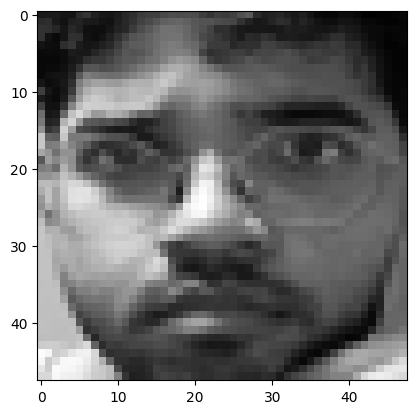


0: 640x640 1 face, 172.9ms
Speed: 4.1ms preprocess, 172.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


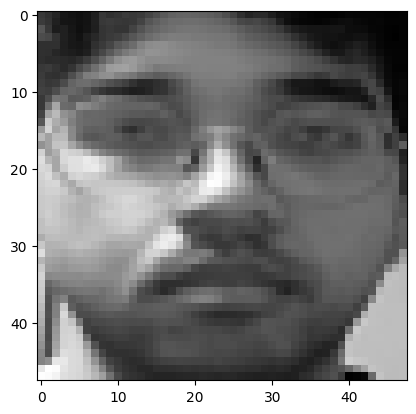


0: 640x640 1 face, 178.0ms
Speed: 5.1ms preprocess, 178.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


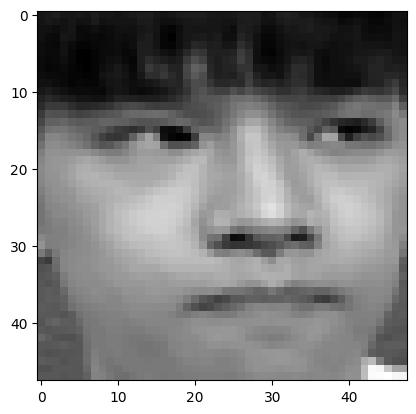


0: 640x640 (no detections), 191.5ms
Speed: 5.1ms preprocess, 191.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 300.6ms
Speed: 3.9ms preprocess, 300.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


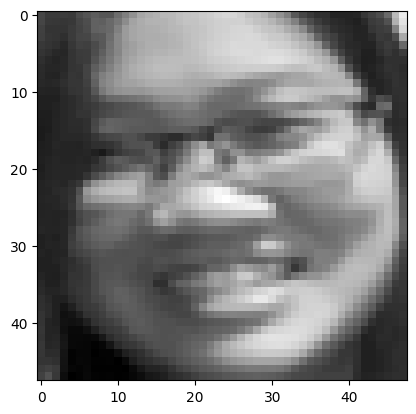


0: 640x640 (no detections), 194.5ms
Speed: 5.0ms preprocess, 194.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 171.6ms
Speed: 5.1ms preprocess, 171.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


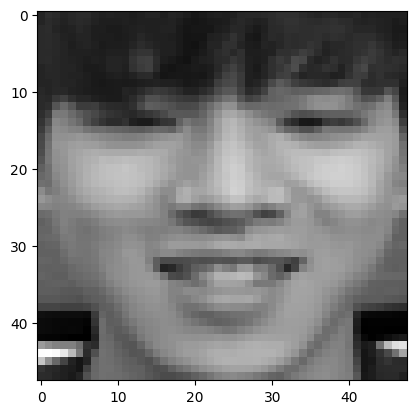


0: 640x640 1 face, 189.2ms
Speed: 4.9ms preprocess, 189.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


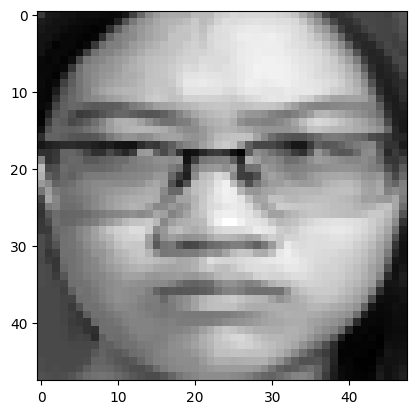


0: 640x640 1 face, 183.1ms
Speed: 5.5ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


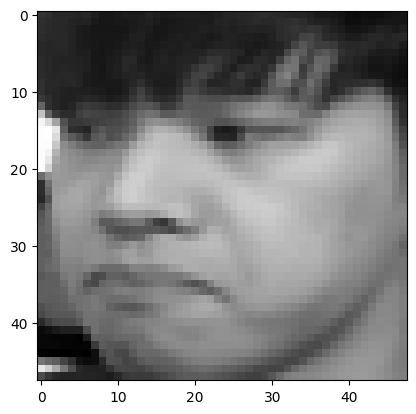


0: 640x640 1 face, 346.1ms
Speed: 6.7ms preprocess, 346.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


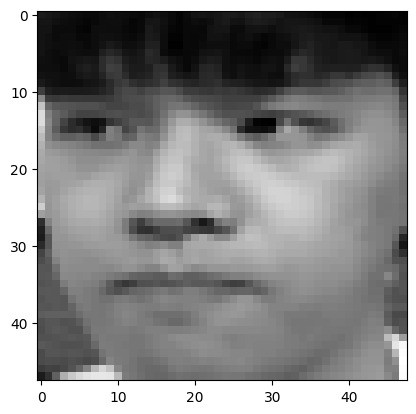


0: 640x640 1 face, 212.1ms
Speed: 9.7ms preprocess, 212.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


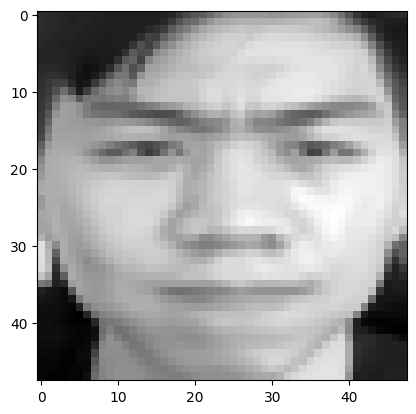


0: 640x640 1 face, 252.7ms
Speed: 9.0ms preprocess, 252.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


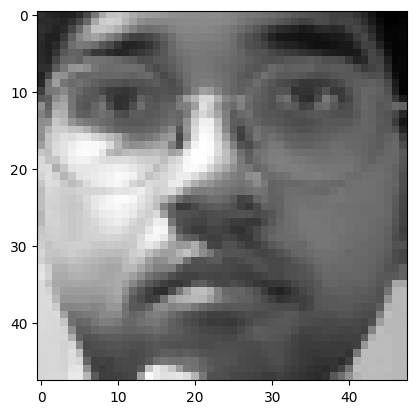


0: 640x640 (no detections), 190.2ms
Speed: 3.9ms preprocess, 190.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 247.0ms
Speed: 5.7ms preprocess, 247.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


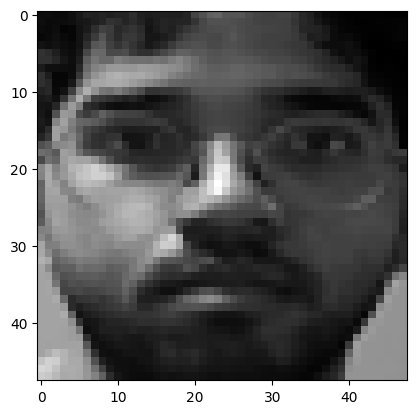


0: 640x640 1 face, 295.8ms
Speed: 6.5ms preprocess, 295.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


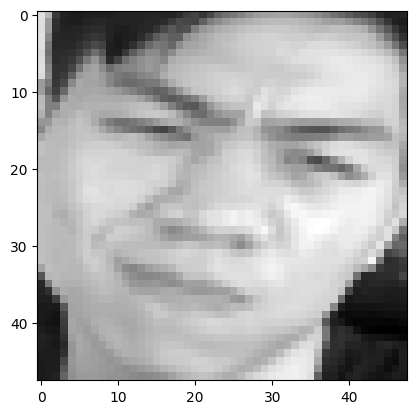


0: 640x640 1 face, 231.0ms
Speed: 11.6ms preprocess, 231.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


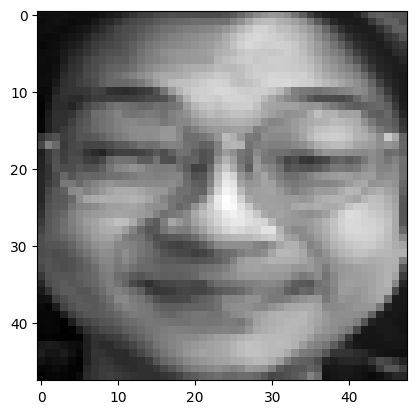


0: 640x640 1 face, 287.3ms
Speed: 4.8ms preprocess, 287.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


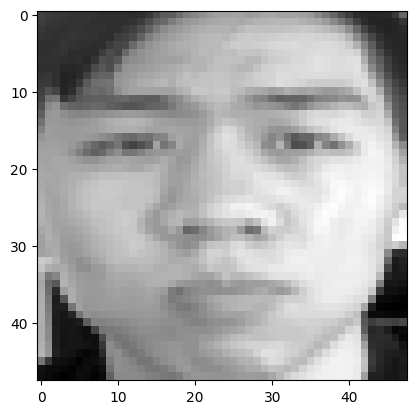


0: 640x640 1 face, 176.6ms
Speed: 6.4ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


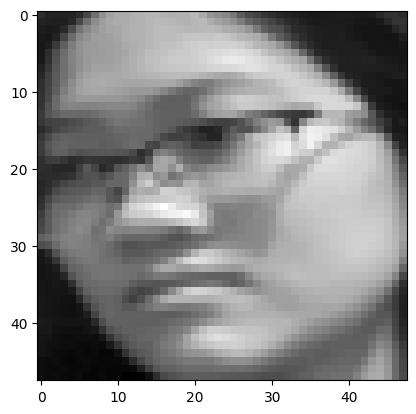


0: 640x640 1 face, 183.6ms
Speed: 4.4ms preprocess, 183.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


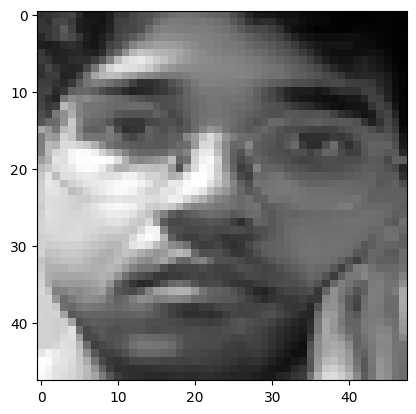


0: 640x640 1 face, 192.2ms
Speed: 4.9ms preprocess, 192.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


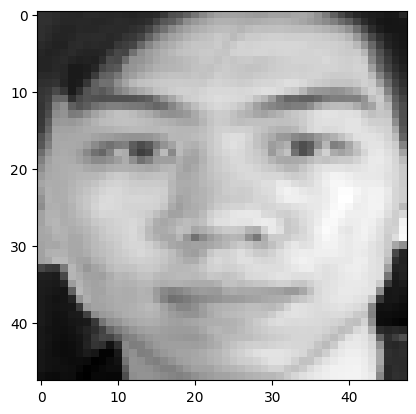


0: 640x640 1 face, 282.8ms
Speed: 5.2ms preprocess, 282.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


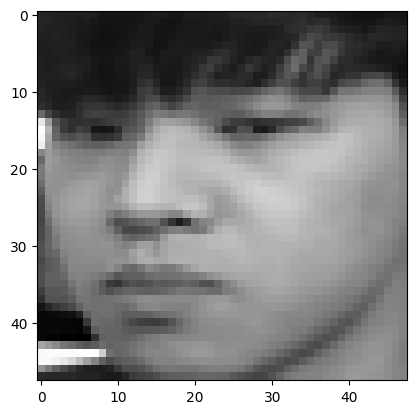


0: 640x640 1 face, 189.1ms
Speed: 5.6ms preprocess, 189.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


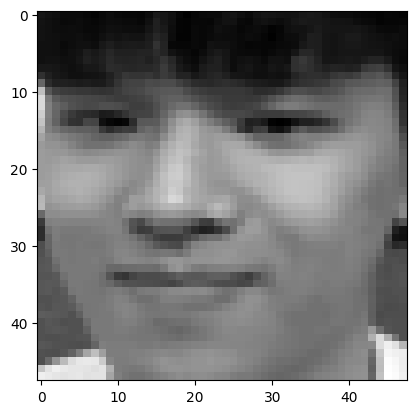


0: 640x640 1 face, 180.5ms
Speed: 5.4ms preprocess, 180.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


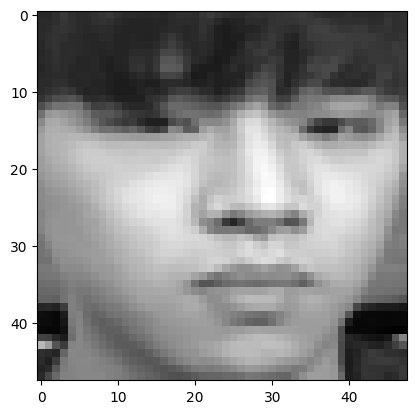


0: 640x640 1 face, 192.1ms
Speed: 6.0ms preprocess, 192.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


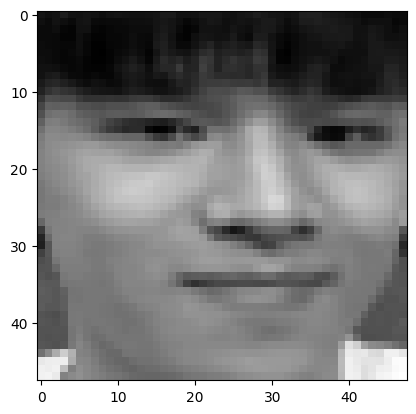


0: 640x640 (no detections), 311.3ms
Speed: 5.1ms preprocess, 311.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 176.5ms
Speed: 4.0ms preprocess, 176.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


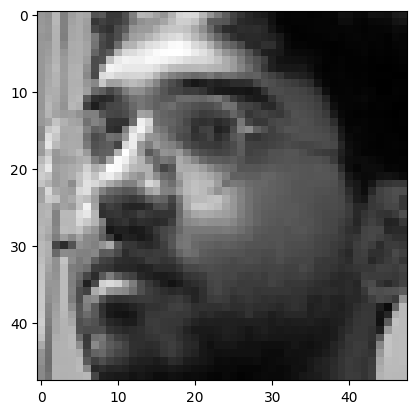


0: 640x640 1 face, 275.0ms
Speed: 4.7ms preprocess, 275.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


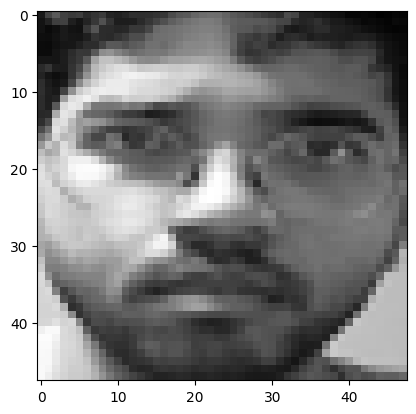


0: 640x640 1 face, 179.8ms
Speed: 5.0ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


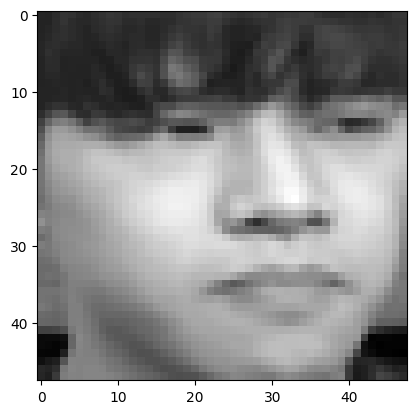


0: 640x640 1 face, 322.4ms
Speed: 4.5ms preprocess, 322.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


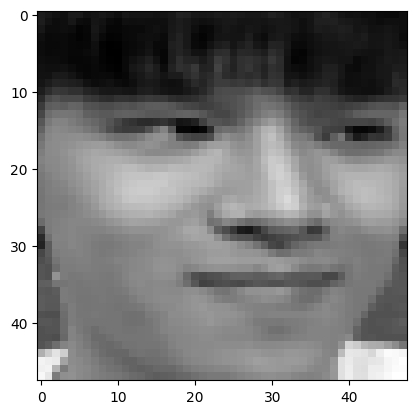


0: 640x640 1 face, 195.1ms
Speed: 4.5ms preprocess, 195.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


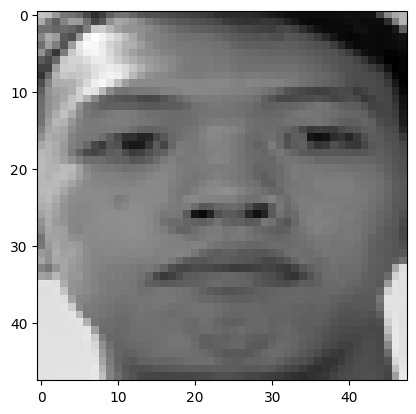


0: 640x640 1 face, 188.7ms
Speed: 5.4ms preprocess, 188.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


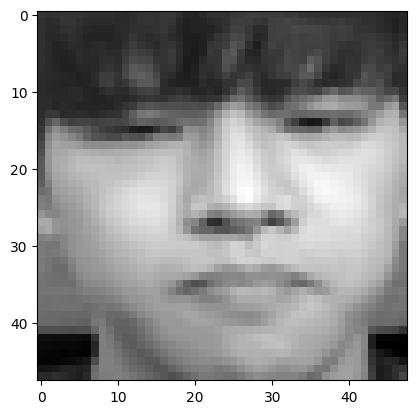


0: 640x640 1 face, 300.4ms
Speed: 4.9ms preprocess, 300.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


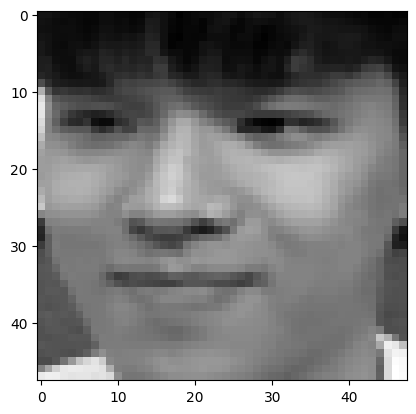


0: 640x640 1 face, 230.6ms
Speed: 5.6ms preprocess, 230.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


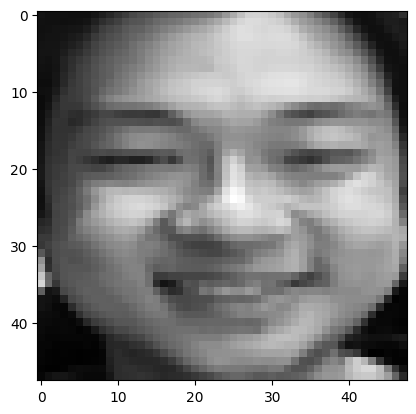


0: 640x640 1 face, 187.4ms
Speed: 5.3ms preprocess, 187.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


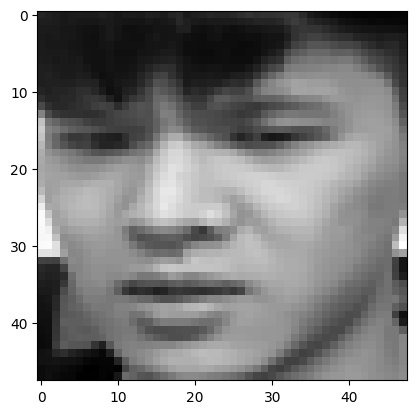


0: 640x640 1 face, 307.9ms
Speed: 8.0ms preprocess, 307.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


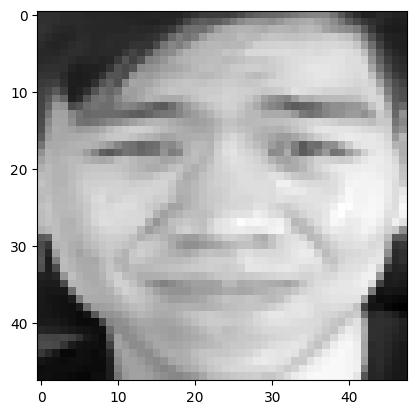


0: 640x640 1 face, 187.0ms
Speed: 4.9ms preprocess, 187.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


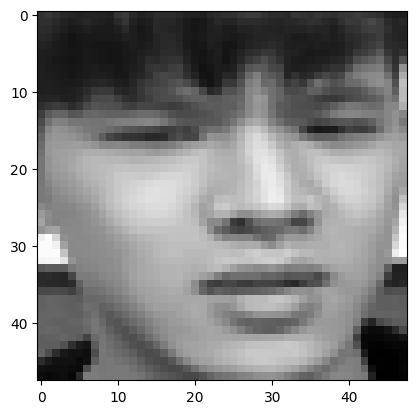


0: 640x640 (no detections), 206.8ms
Speed: 5.0ms preprocess, 206.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 207.5ms
Speed: 10.1ms preprocess, 207.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


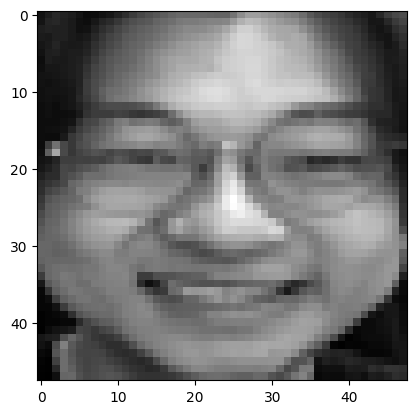


0: 640x640 1 face, 424.7ms
Speed: 6.1ms preprocess, 424.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


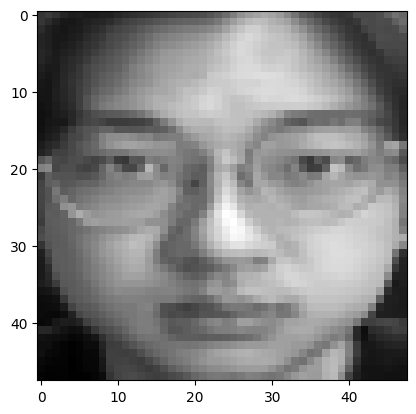


0: 640x640 1 face, 190.5ms
Speed: 4.7ms preprocess, 190.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


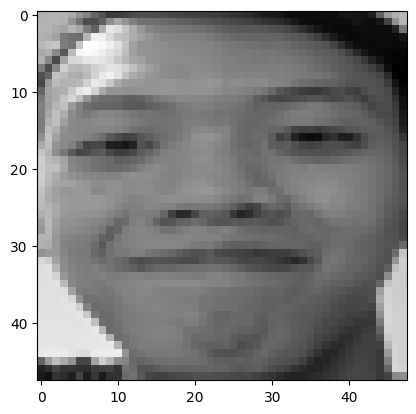


0: 640x640 1 face, 192.6ms
Speed: 5.4ms preprocess, 192.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


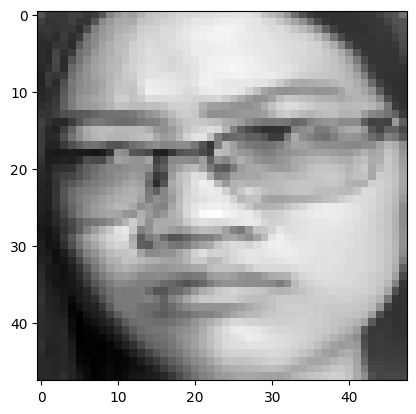


0: 640x640 1 face, 178.6ms
Speed: 5.1ms preprocess, 178.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


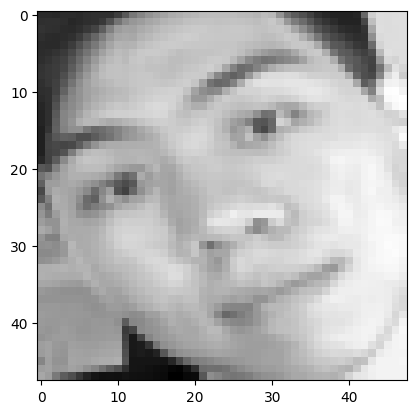


0: 640x640 1 face, 285.3ms
Speed: 5.6ms preprocess, 285.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


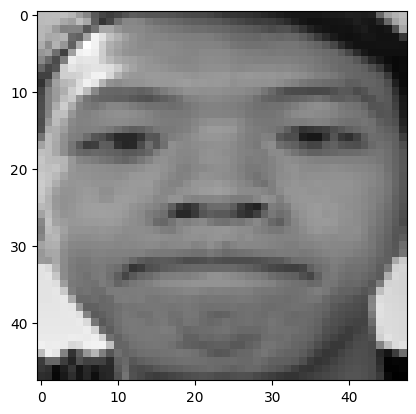


0: 640x640 1 face, 195.8ms
Speed: 4.9ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


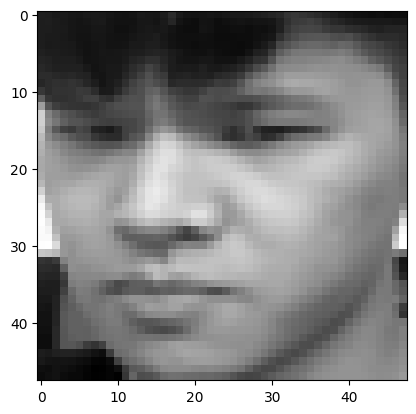


0: 640x640 1 face, 187.6ms
Speed: 4.4ms preprocess, 187.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


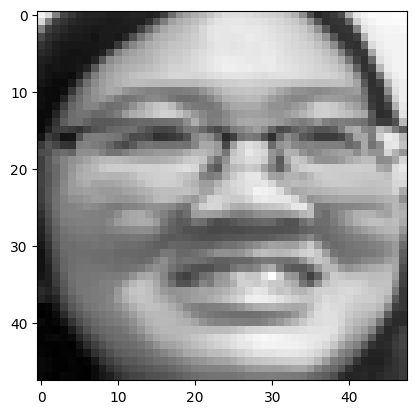


0: 640x640 1 face, 323.6ms
Speed: 5.4ms preprocess, 323.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


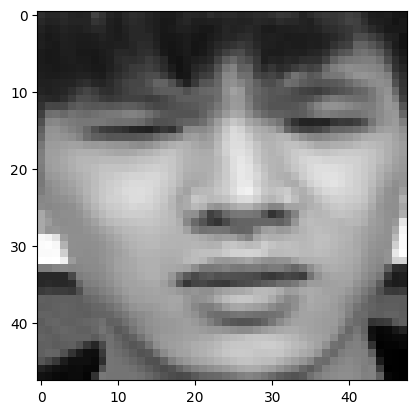


0: 640x640 1 face, 192.7ms
Speed: 5.4ms preprocess, 192.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


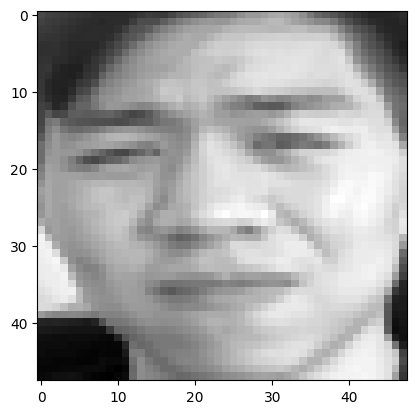


0: 640x640 1 face, 226.2ms
Speed: 6.6ms preprocess, 226.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


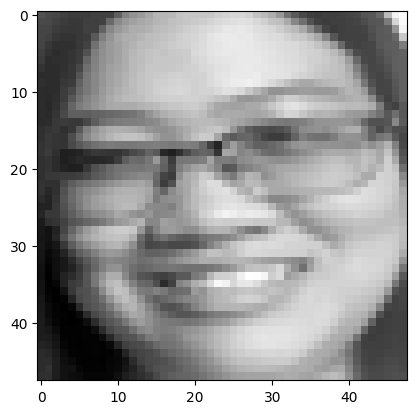


0: 640x640 1 face, 211.1ms
Speed: 16.6ms preprocess, 211.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


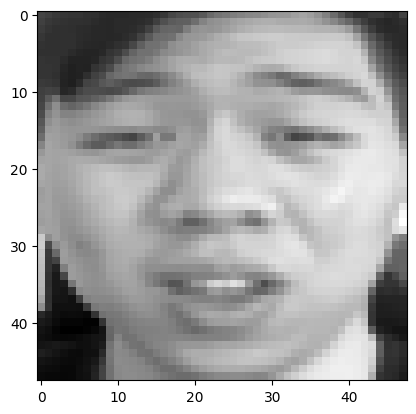


0: 640x640 1 face, 342.5ms
Speed: 5.1ms preprocess, 342.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


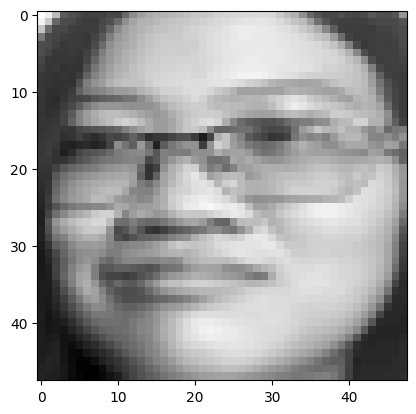


0: 640x640 1 face, 209.4ms
Speed: 6.9ms preprocess, 209.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


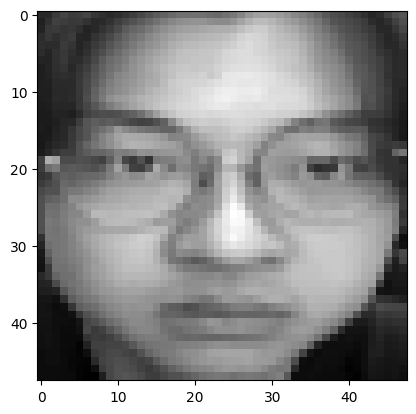


0: 640x640 1 face, 211.3ms
Speed: 5.8ms preprocess, 211.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


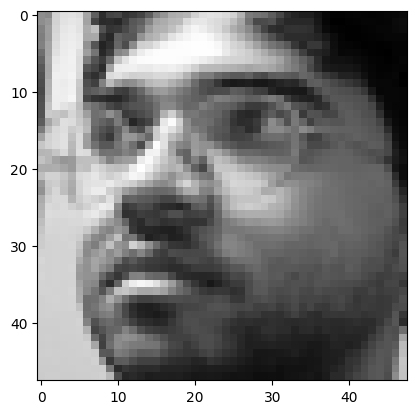


0: 640x640 (no detections), 268.7ms
Speed: 8.2ms preprocess, 268.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 203.5ms
Speed: 4.7ms preprocess, 203.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


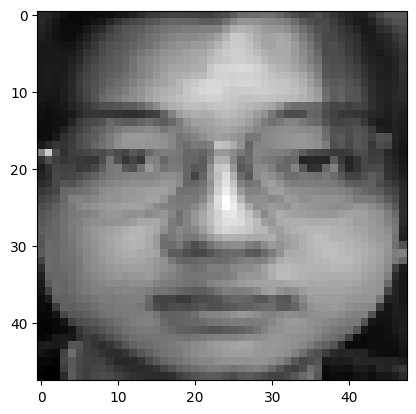


0: 640x640 1 face, 212.6ms
Speed: 5.2ms preprocess, 212.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


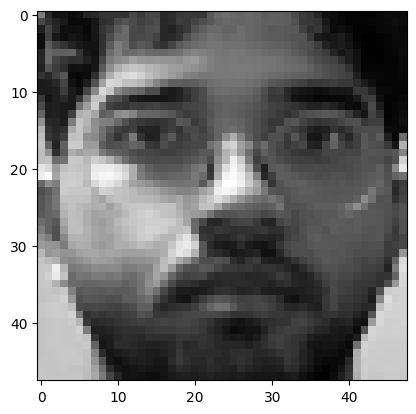


0: 640x640 1 face, 229.1ms
Speed: 5.2ms preprocess, 229.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


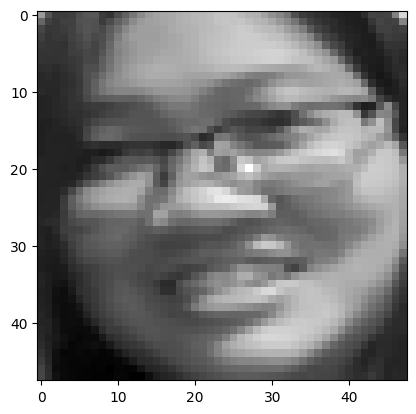


0: 640x640 1 face, 377.7ms
Speed: 8.6ms preprocess, 377.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


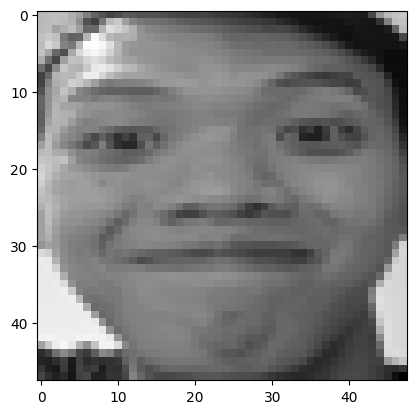


0: 640x640 1 face, 224.3ms
Speed: 7.3ms preprocess, 224.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


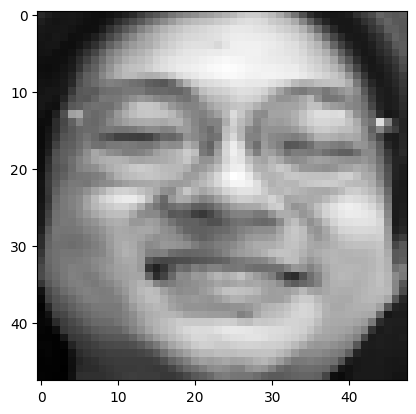


0: 640x640 1 face, 285.2ms
Speed: 9.5ms preprocess, 285.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


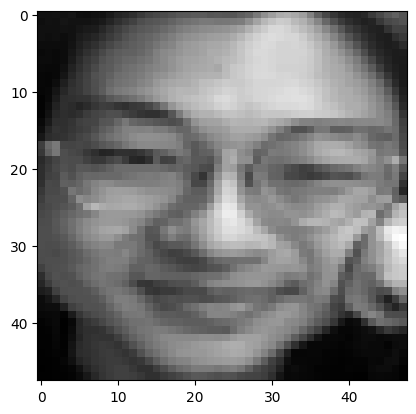


0: 640x640 1 face, 240.5ms
Speed: 8.3ms preprocess, 240.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


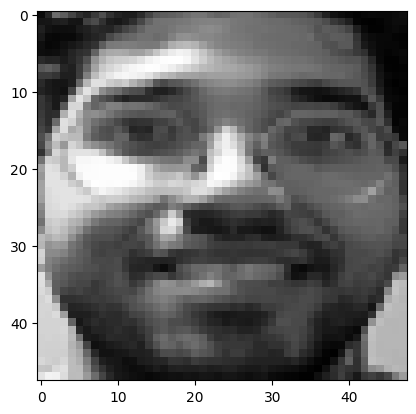


0: 640x640 1 face, 345.3ms
Speed: 7.4ms preprocess, 345.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


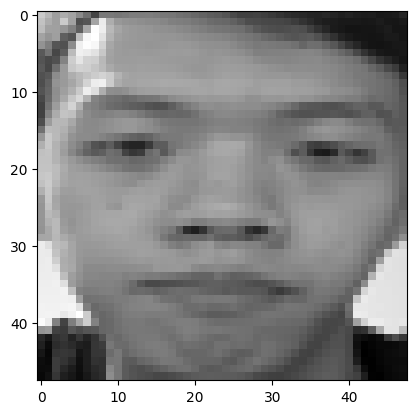


0: 640x640 1 face, 245.5ms
Speed: 6.3ms preprocess, 245.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


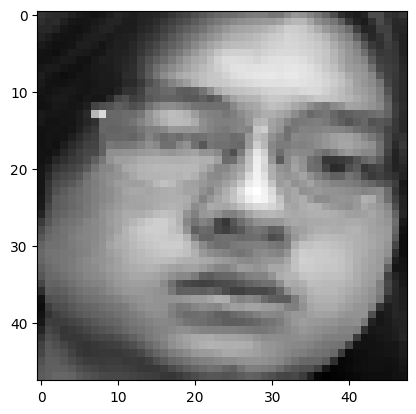


0: 640x640 1 face, 262.9ms
Speed: 6.0ms preprocess, 262.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


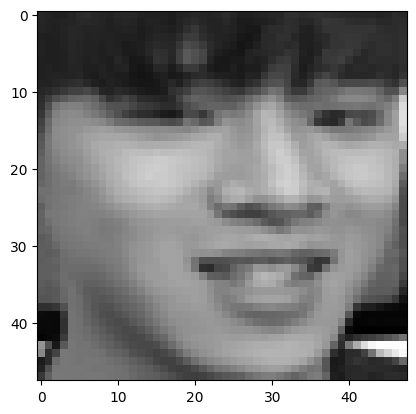


0: 640x640 1 face, 394.4ms
Speed: 10.1ms preprocess, 394.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


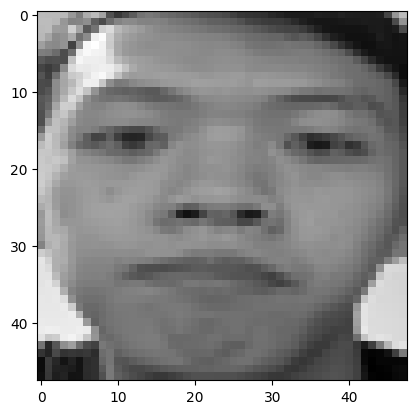


0: 640x640 (no detections), 241.3ms
Speed: 27.6ms preprocess, 241.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 199.4ms
Speed: 5.0ms preprocess, 199.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


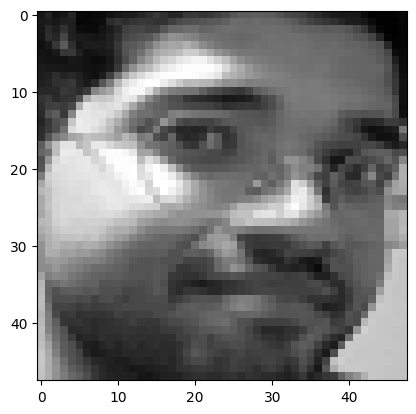


0: 640x640 1 face, 209.3ms
Speed: 5.2ms preprocess, 209.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


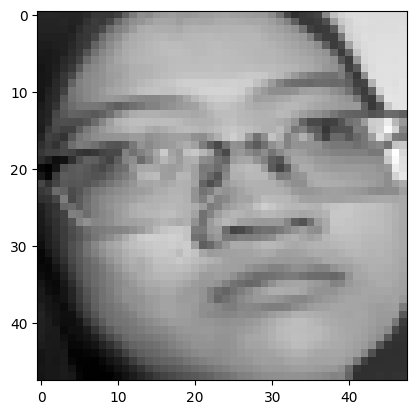


0: 640x640 1 face, 334.2ms
Speed: 5.3ms preprocess, 334.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


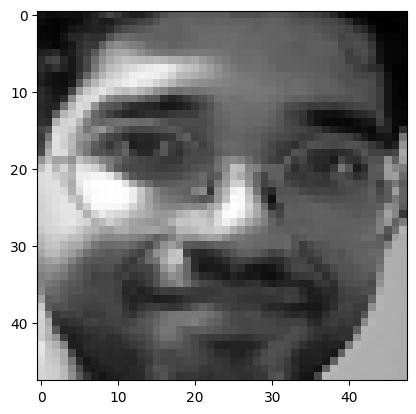


0: 640x640 1 face, 206.5ms
Speed: 5.0ms preprocess, 206.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


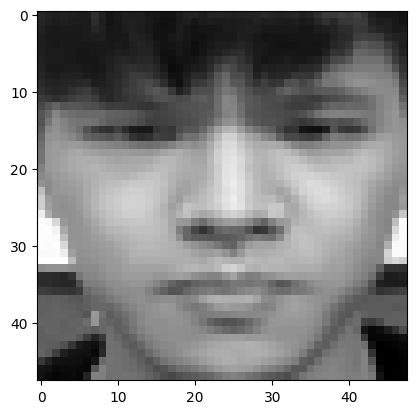


0: 640x640 1 face, 249.0ms
Speed: 8.0ms preprocess, 249.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


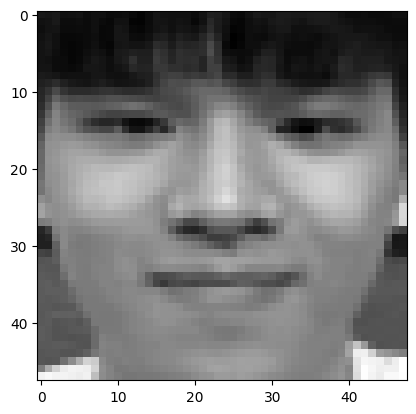


0: 640x640 (no detections), 376.8ms
Speed: 14.9ms preprocess, 376.8ms inference, 12.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 447.0ms
Speed: 5.7ms preprocess, 447.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


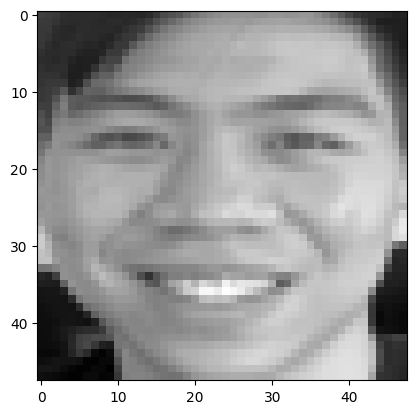


0: 640x640 1 face, 376.2ms
Speed: 10.0ms preprocess, 376.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


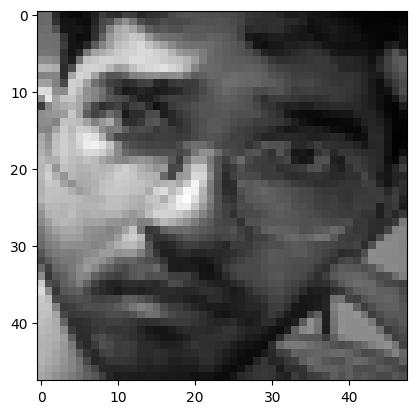


0: 640x640 1 face, 284.7ms
Speed: 18.6ms preprocess, 284.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


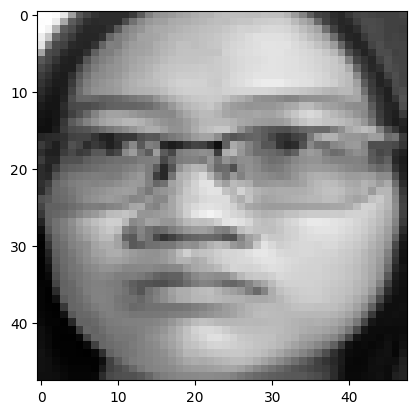


0: 640x640 1 face, 222.6ms
Speed: 5.0ms preprocess, 222.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


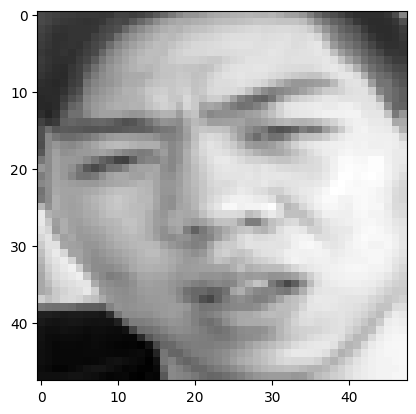


0: 640x640 1 face, 237.6ms
Speed: 7.3ms preprocess, 237.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


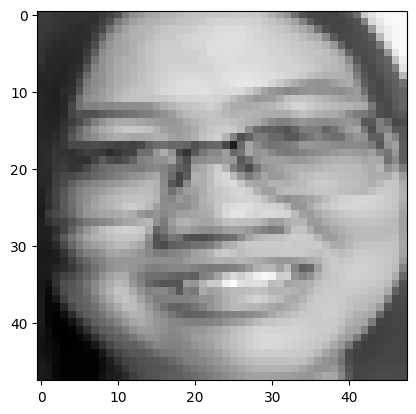


0: 640x640 1 face, 228.9ms
Speed: 7.4ms preprocess, 228.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


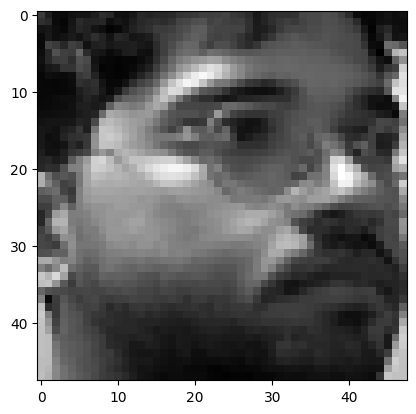


0: 640x640 1 face, 229.3ms
Speed: 6.1ms preprocess, 229.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


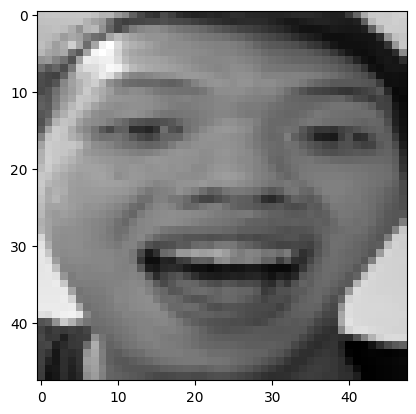


0: 640x640 1 face, 243.1ms
Speed: 6.6ms preprocess, 243.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


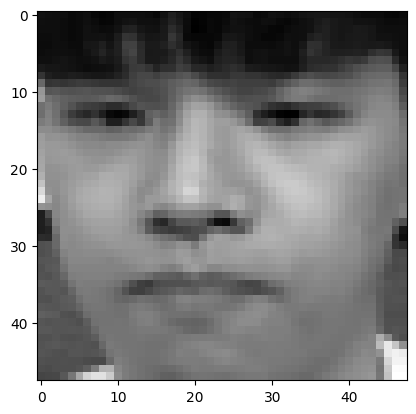


0: 640x640 1 face, 214.6ms
Speed: 5.4ms preprocess, 214.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


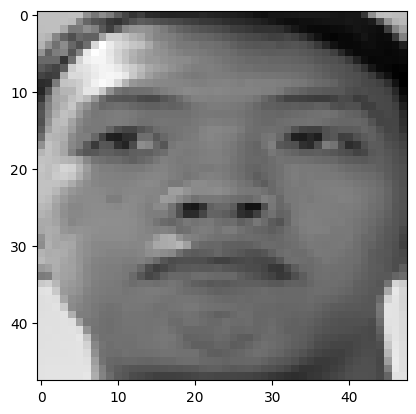


0: 640x640 1 face, 207.2ms
Speed: 6.4ms preprocess, 207.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


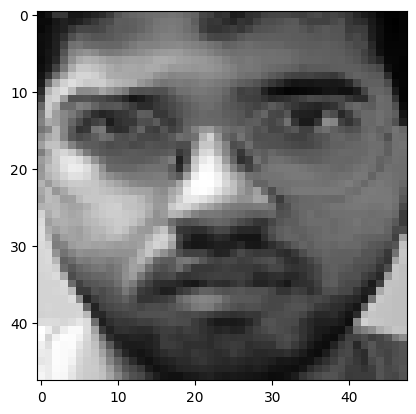


0: 640x640 1 face, 330.3ms
Speed: 5.4ms preprocess, 330.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


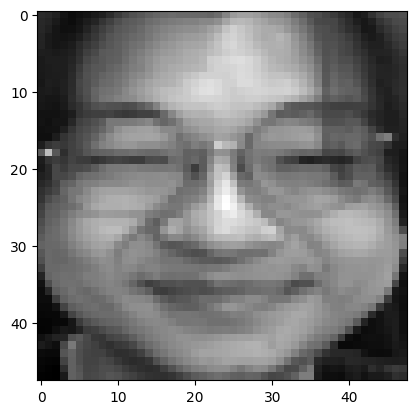


0: 640x640 1 face, 211.1ms
Speed: 7.3ms preprocess, 211.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


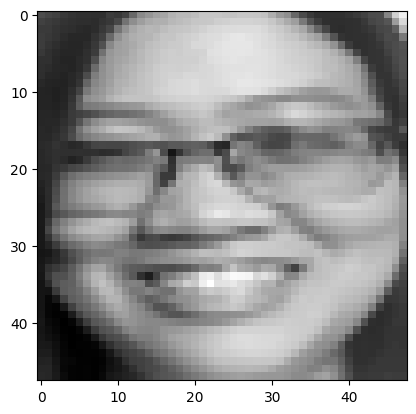


0: 640x640 1 face, 202.2ms
Speed: 5.1ms preprocess, 202.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


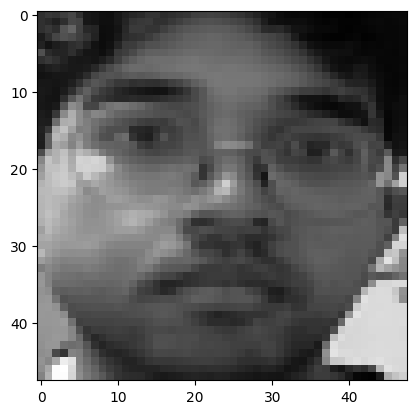


0: 640x640 1 face, 318.6ms
Speed: 6.2ms preprocess, 318.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


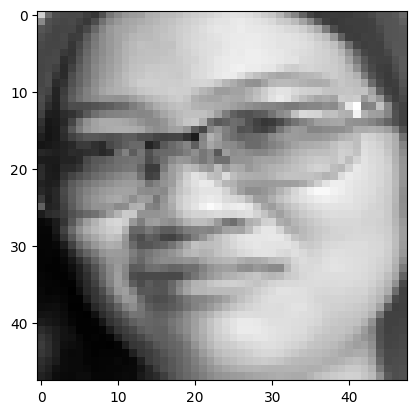


0: 640x640 1 face, 207.2ms
Speed: 4.5ms preprocess, 207.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


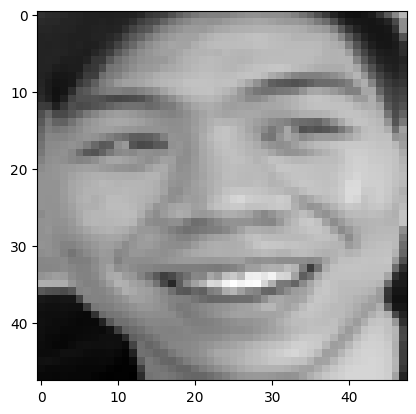


0: 640x640 1 face, 205.5ms
Speed: 5.2ms preprocess, 205.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


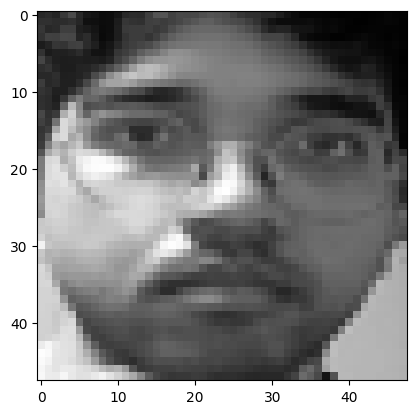


0: 640x640 1 face, 198.1ms
Speed: 4.7ms preprocess, 198.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


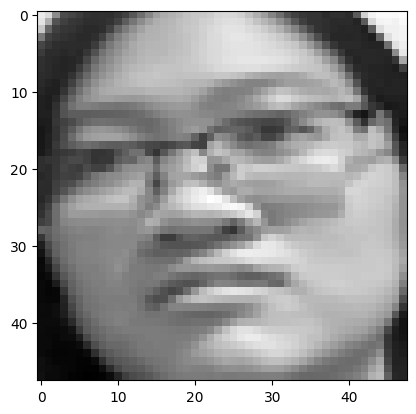


0: 640x640 1 face, 202.7ms
Speed: 6.4ms preprocess, 202.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


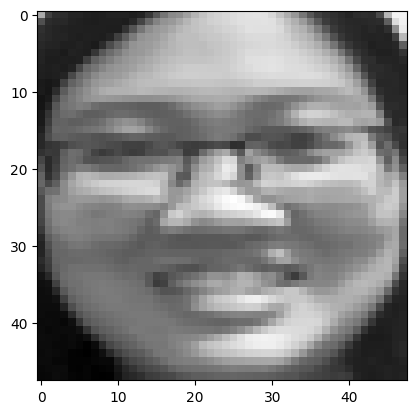


0: 640x640 1 face, 225.6ms
Speed: 4.9ms preprocess, 225.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


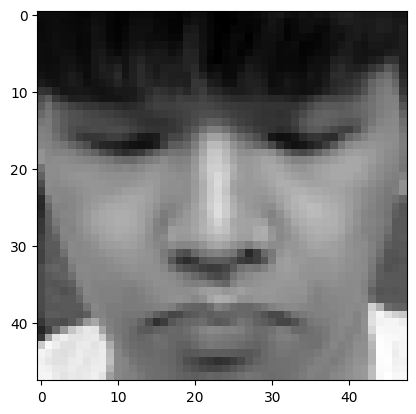


0: 640x640 1 face, 201.7ms
Speed: 5.3ms preprocess, 201.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


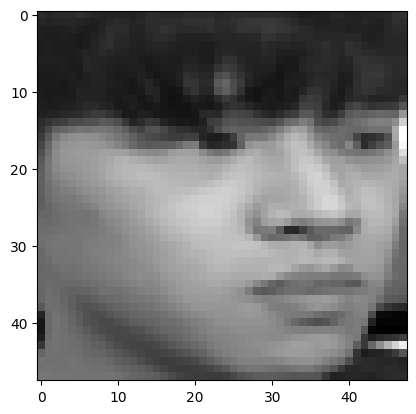


0: 640x640 1 face, 341.1ms
Speed: 5.0ms preprocess, 341.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


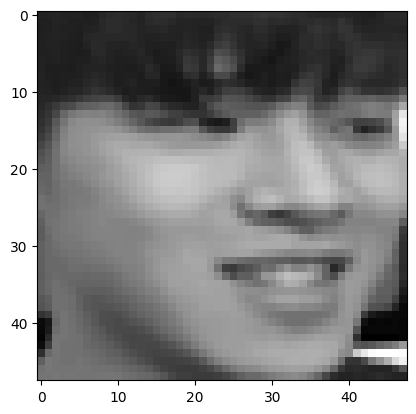


0: 640x640 1 face, 197.7ms
Speed: 5.2ms preprocess, 197.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


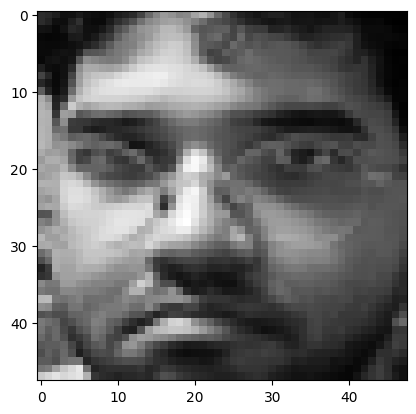


0: 640x640 1 face, 198.5ms
Speed: 4.5ms preprocess, 198.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


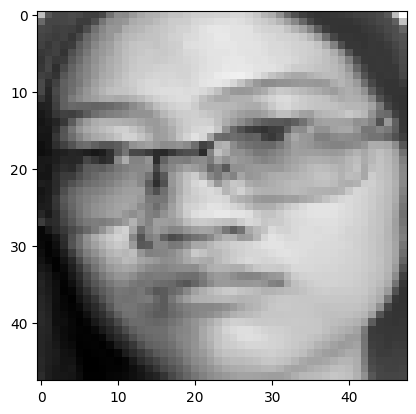


0: 640x640 1 face, 190.0ms
Speed: 4.2ms preprocess, 190.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


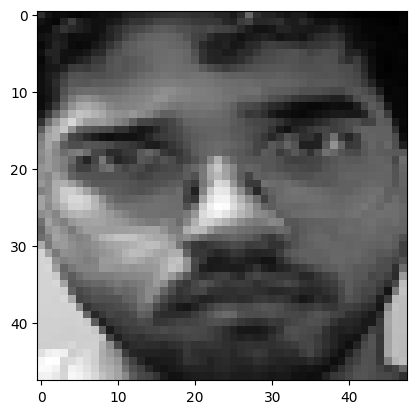

In [19]:
num_faces = 0
#create a dataset with cropped faces and its corresponding label
X_cropped = []
y_cropped = []
for i in range(140):
  #  print(i)
    face = np.array(X[i], dtype = 'uint8')
    faces = face_classifier.predict(face)
    boxes = faces[0].boxes.xyxy.tolist()
    if boxes:
        num_faces += 1
        #extract the face based on the output from the YOLOv8 model        
        left, bottom, right, top = boxes[0]
        cropped_face = face[int(bottom):int(top), int(left):int(right)]
        #resize cropped face to a std shape, 100x100 for now but can adjust this
        pil_face = Image.fromarray(np.uint8(cropped_face)).convert('L')
        pil_face = pil_face.resize((48, 48))
        numpy_cropped_face = np.array(pil_face)
        #append this to the new list containing all cropped faces
        X_cropped.append(numpy_cropped_face)
        corresponding_label = y[i]
        #append the labels to the new label list
        y_cropped.append(corresponding_label)
        #uncomment below lines of code to see the cropped face visualisation
        imshow(numpy_cropped_face, cmap = 'gray')
        plt.show()
    


In [20]:
#Run modelling in these cells
X_cropped = np.array(X_cropped)
#flatten the image into 1d vector that is suitable into input to classical ML models
X_log_reg_input = X_cropped.reshape(X_cropped.shape[0], X_cropped.shape[1] * X_cropped.shape[2])

In [21]:
y_log_reg = np.argmax(y_cropped, axis = 1)

### Logistic regression.
In this cell, we shall try a simple logistic regression model as a baseline. We expect the model to not perform well because the data we have is far less than the dimension.

In [13]:
#train, test split

X_train, X_test, y_train, y_test = train_test_split(X_log_reg_input, y_log_reg, test_size=0.2)

In [14]:
X_test.shape

(28, 10000)

In [15]:
log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

/Users/saxyrinchen/.pyenv/versions/3.8.11/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
#evaluate the algorithm

y_pred = log_reg.predict(X_test)

In [17]:
y_pred

array([5, 5, 0, 0, 1, 0, 3, 0, 5, 5, 5, 3, 3, 1, 2, 0, 0, 3, 5, 1, 4, 3, 4, 0, 1, 3, 5, 2])

In [18]:
#Logistic regression performs much better than a random model but still not as good as expected
accuracy_score(y_test, y_pred)

0.5357142857142857

In [11]:
#testing pretrained

pretrained_model = keras.models.load_model('../../app\src/Mood_detector/trained_emotion.keras')

In [17]:
pretrained_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm1                     │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_11 (Conv2D)                │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm12                    │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_21 (Conv2D)                │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm21                    │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool2 (MaxPooling2D)        │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm3                     │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_31 (Conv2D)                │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm31                    │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool3 (MaxPooling2D)        │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm4                     │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_41 (Conv2D)                │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm41                    │ (None, 6, 6, 512)      │         2,04

 Total params: 21,641,815 (82.56 MB)

 Trainable params: 7,212,743 (27.51 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 14,425,488 (55.03 MB)

In [19]:
pretrained_input = np.array(X_cropped).reshape((138, 48, 48, 1))

In [30]:
output = pretrained_model.predict(pretrained_input)
output.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


(138, 7)

(138, 6)

In [35]:
class_predictions = np.argmax(output[:, [0, ] + list(range(2,7))], axis = 1)

5

In [27]:
max(class_predictions)

6

In [36]:
accuracy_score(y_true=y_log_reg, y_pred=class_predictions)

0.42028985507246375

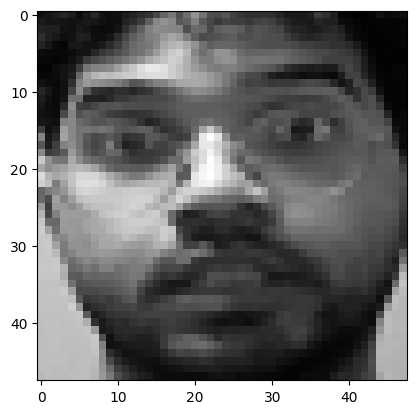

In [26]:
imshow(np.array(pretrained_input[0], dtype='uint8'), cmap='gray')